## Exercici
Parteix el conjunt de dadesDelayedFlights.csv en train i test. Estudia els dos conjunts per separat, a nivell descriptiu.

In [123]:
import os
import numpy as np
import pandas as pd

import math
from scipy.stats import shapiro
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import category_encoders

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#definim una funció per dibuixar les distribucions en boxplot de les columnes especificades d'un dataframe
def distplots(df, cols, color="m", orient="h"):
    cols = list(cols)
    rows = math.ceil(len(cols)/5)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(20,rows*4))
    for i, col in zip(range(len(cols)), cols):
        plt.subplot(rows, 5, i+1)
        if orient == "h":
            sns.boxplot(x=col, data=df, color=color, orient=orient, linewidth=1 , width=.5)
            plt.xlim(df[col].quantile(q=.5), df[col].quantile(q=.95))
            plt.title(col, y=.85)
            plt.xlabel("")
        elif orient == "v":
            sns.boxplot(y=col, data=df, color=color, orient=orient, linewidth=1 , width=.5)
            plt.ylim(df[col].quantile(q=.5), df[col].quantile(q=.95))
            plt.title(col)
            plt.ylabel("")
    plt.show()

In [124]:
pd.options.display.max_columns = None

datasets_path = r"D:\Oscar\FORMACIO\DIGITAL\DATA SCIENCE with Python\Datasets" + os.sep
file = datasets_path + "DelayedFlights.csv"
df = pd.read_csv(file, index_col=0)
df.head(3)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,"2,003.00",1955,"2,211.00",2225,WN,335,N712SW,128.00,150.00,116.00,-14.00,8.00,IAD,TPA,810,4.00,8.00,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.00,735,"1,002.00",1000,WN,3231,N772SW,128.00,145.00,113.00,2.00,19.00,IAD,TPA,810,5.00,10.00,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.00,620,804.00,750,WN,448,N428WN,96.00,90.00,76.00,14.00,8.00,IND,BWI,515,3.00,17.00,0,N,0,NaN,NaN,NaN,NaN,NaN


Documentació de la descripció de les columnes a [Get the data](http://stat-computing.org/dataexpo/2009/the-data.html)
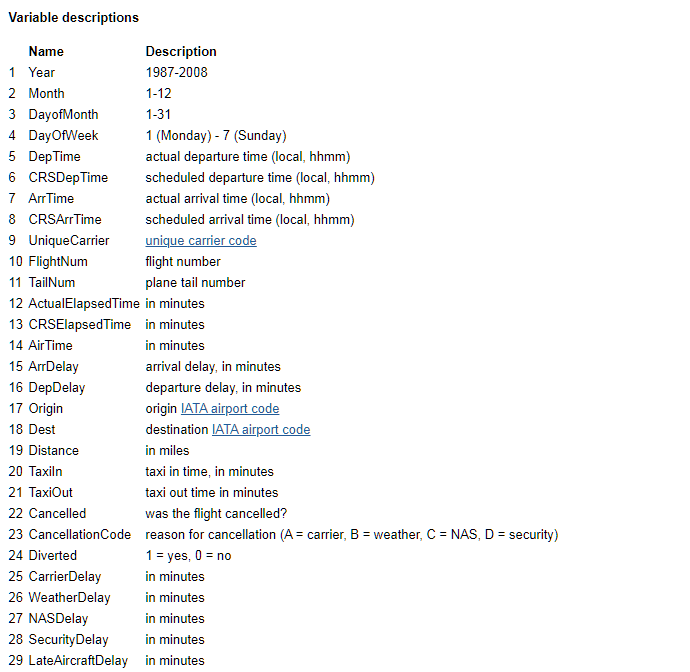

### train-test
*Utilitzem **train-test** en problemes de **clasificassió** o **regressió** per a l'evaluació d'algorismes d'aprenentatge **supervisat**.*

*Haurem de seleccionar la variable objectiu. Donat que el títol del dataset és delayed flights, agafarem **ArrDelay**, o vist d'una altra forma, la predicció de l'hora d'arribada real*.

*Com volem predir una variable numèrica contínua hauriem de fer servir models de regressió.*

**Consideracions prèvies per l'elecció de les variables**

*Esbocem un timeline amb les variables temporals de vol (en hores i "timedeltas") que ens dona el dataset.*

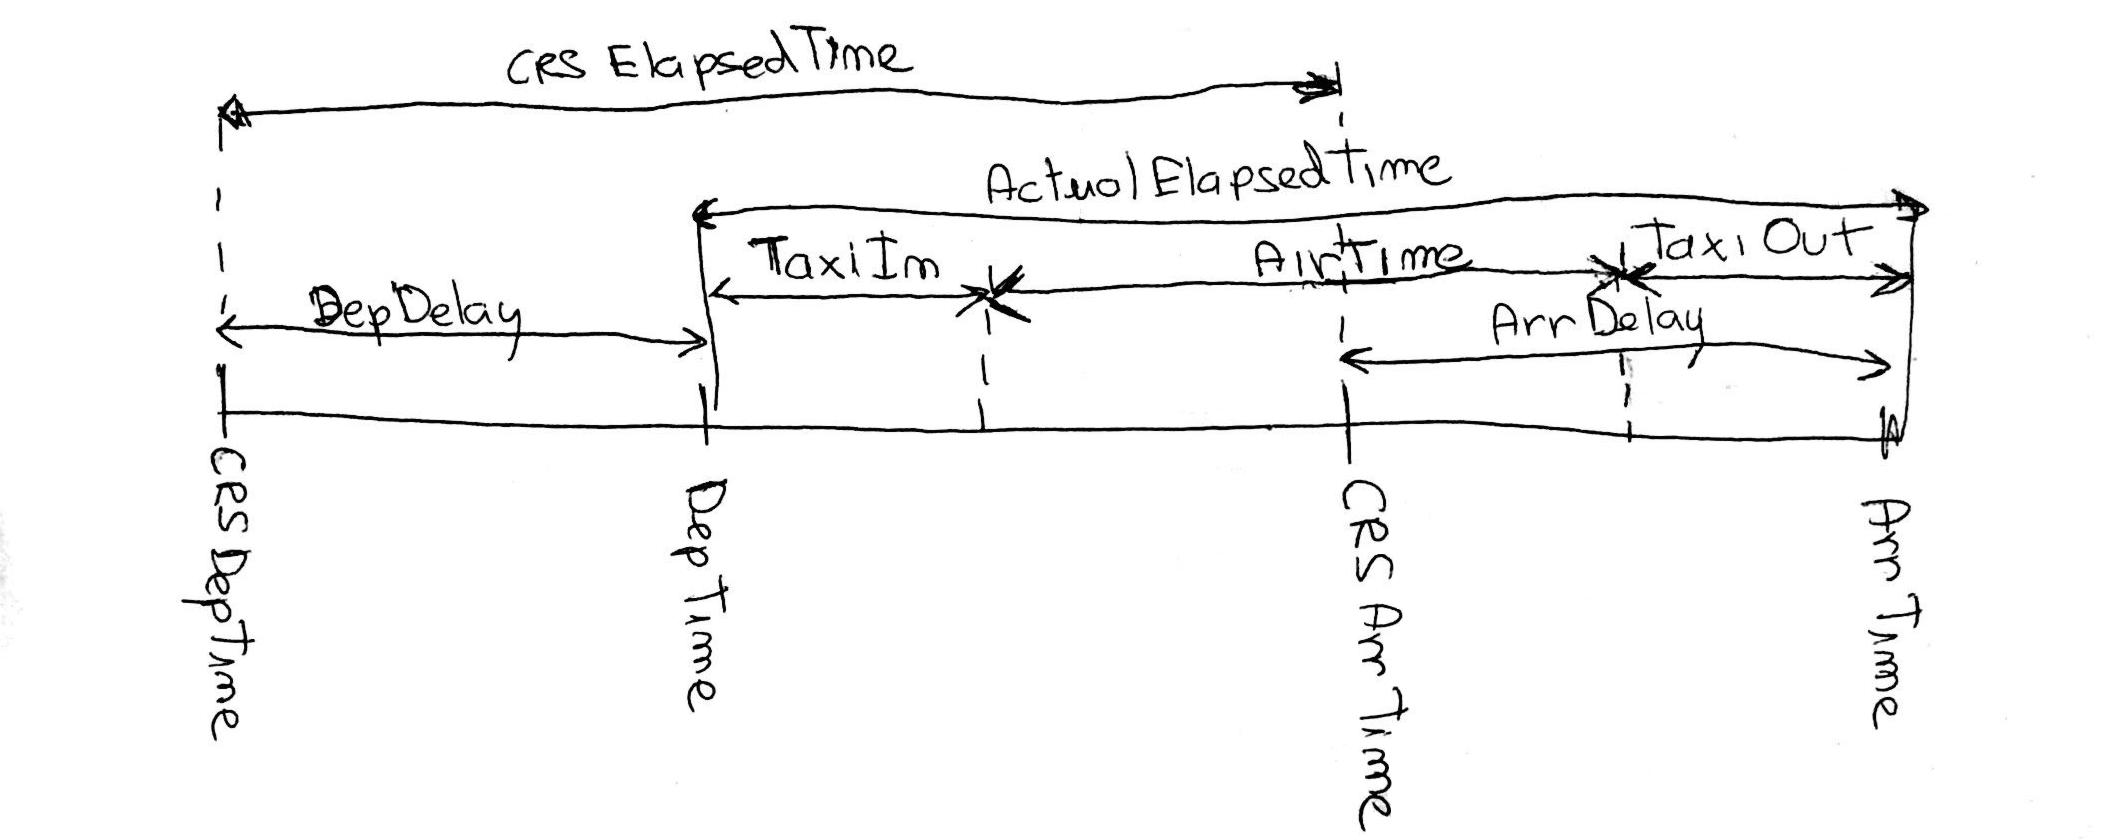

*Tot i que no se'ns demana cap model de ML a l'exercici ni tampoc seria necessari per fer-lo que les prediccions tinguin una lògica temporal, ens posarem en la situació de partida d'un cas pràctic real i ho plantejarem com a tal.*

*Com l'elaboració del mencionat model dependrà de la informació que disposarem a l'hora de fer la predicció, és a dir, el dataset ens dóna la informació de l'hora de sortida real (i retard de sortida) i de l'hora d'arribada real (amb un retard d'arribada), així com el temps real transcorregut (Taxis + Aire), però en un cas real ens podriem plantejar la qüestió de **en quin moment haurem de fer aquesta predicció**?*

*Per exemple, si volem elaborar el model per fer la predicció abans de volar únicament tindrem les dades de vol programades i encara no coneixerem dades com el retard de sortida, o els temps reals de tot el recorregut, i podem estalviar recursos de fer un model amb entrades de les que no disposarem. I, d'altra banda, ho desconec, però poder no és possible per un model de predicció ja elaborat, obviar variables d'entrada en el càlcul de prediccions.*

*Per fer l'exercici, decidim que prendrem com a objectiu final la predicció d'aquest retard d'arribada en el moment que l'avió començi el rodatge per la pista, és a dir, quan comenci a moure's.*

*En aquest punt sabrem*:
- el retard de sortida **DepDelay** 
- hores de sortida programada i real **CRSDepTime** i **DepTime**(CRSDepTime+DepDelay)
- duració programada del vol **CRSElapsedTime**

*Pero no tindrem informació de*:
- temps de recorregut **ActualElapsedTime (TaxiIn + TaxiOut + AirTime)**
- hora d'arribada **ArrTime**

*Vam veure en un excercici anterior que hi havia una alta correlació entre el retard de sortida i el d'arribada. Així que aquest moment de predicció em sembla l'idoni per fer l'excercici, tot i que seria molt pòssible voler elaborar un model per un moment anterior i tenint únicament les dades programades del vol. Inclús podriem fer-lo de instants posteriors contant amb més informació del mateix i, conseqüentment, afegint més variables al model*

In [125]:
#Verifiquem que TaxiIn + TaxiOut + AirTime = ActualElapsedTime. Y veiem q la diferència és sempre 0, exepte on hi ha nulls
data = df["TaxiIn"] + df["TaxiOut"] + df["AirTime"]
data = pd.concat([data, df["ActualElapsedTime"], data - df["ActualElapsedTime"]], 
                 keys=["TaxiIn+TaxiOut+AirTime", "ActualElapsedTime", "Diferència"], axis=1)
print(data.sample(5))
print("Diferències úniques:", data["Diferència"].unique())

         TaxiIn+TaxiOut+AirTime  ActualElapsedTime  Diferència
6959478                  155.00             155.00        0.00
6923128                  204.00             204.00        0.00
2983094                  338.00             338.00        0.00
1438069                  345.00             345.00        0.00
3294441                   78.00              78.00        0.00
Diferències úniques: [ 0. nan]


In [126]:
#veiem que tenim vols amb una duració programada negativa
cols = df.columns[df.columns.str.contains("CRS")].append(pd.Index(["Diverted", "Cancelled"]))
df[df.CRSElapsedTime < 0][cols]

,CRSDepTime,CRSArrTime,CRSElapsedTime,Diverted,Cancelled
768964,1638,1729,-9.00,1,0
1358057,1756,1735,-21.00,0,0
1992427,710,645,-25.00,1,0
1992500,600,648,-12.00,1,0
3171278,600,650,-10.00,1,0
3171282,600,642,-18.00,1,0


In [127]:
#als desviats no els fem cas pq no els utilizarem però, en el que no ho és, sembla que han entrat les dades invertides per
#error doncs té una hora d'arribada programada inferior a la sortida i veient les hores reals del vol ens quadra q sigui així
data = df[(df.CRSElapsedTime < 0) & (df.Diverted == 0)]
i = data.index
cols = cols.drop(["Diverted", "Cancelled"]).append(pd.Index(["DepTime", "ArrTime"]))
print(data[cols])

#intercanviem els valors de les variables i canviem el signe de la duracio programada
df.loc[i, "CRSDepTime"], df.loc[i, "CRSArrTime"] = df.loc[i, "CRSArrTime"], df.loc[i, "CRSDepTime"]
df.loc[i, "CRSElapsedTime"] *= -1
df.loc[i][cols]

         CRSDepTime  CRSArrTime  CRSElapsedTime  DepTime  ArrTime
1358057        1756        1735          -21.00 1,839.00 1,910.00


,CRSDepTime,CRSArrTime,CRSElapsedTime,DepTime,ArrTime
1358057,1735,1756,21.00,"1,839.00","1,910.00"


In [128]:
#eliminem de les dades les variables que de les que no disposarem a l'hora de fer la predicció
drop = ["ActualElapsedTime", "TaxiIn", "TaxiOut", "AirTime", "ArrTime"]
df.drop(columns=drop, inplace=True)

#les columnes d'hora porten l'hora i minut combinats que haurem de desglossar
cols = ["CRSDepTime", "DepTime"]
for col in cols:
    time = df[col].astype("int").astype("str").str.zfill(4)
    df[col.replace("Time", "Hour")] = time.apply(lambda x: x[:2]).astype("int")
    df[col.replace("Time", "Min")] = time.apply(lambda x: x[2:]).astype("int")
    df.drop(columns=col, inplace=True)
df[df.columns[df.columns.str.contains("Dep")]].head()

,DepDelay,CRSDepHour,CRSDepMin,DepHour,DepMin
0,8.00,19,55,20,3
1,19.00,7,35,7,54
2,8.00,6,20,6,28
4,34.00,17,55,18,29
5,25.00,19,15,19,40


In [129]:
#Comprovem nulls, de les variables que en tenen, i observem que la nostra variable objectiu té 8387 NaNs
df.isna().sum()[df.isna().sum() != 0]

TailNum                   5
CRSElapsedTime          198
ArrDelay               8387
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
dtype: int64

In [130]:
#Necessitem sempre dades en la variable objectiu. Eliminarem les instàncies que no tinguin aquesta informació.  
var_y = "ArrDelay"
index = df[var_y][df[var_y].isna()].index
df.drop(index=index, inplace=True)

#Tornem a mirar les variables amb nulls, per observar com han quedat despres d'eliminar els de la sortida.
df.isna().sum()[df.isna().sum() != 0]

TailNum                   3
CarrierDelay         680883
WeatherDelay         680883
NASDelay             680883
SecurityDelay        680883
LateAircraftDelay    680883
dtype: int64

*Per aquestes variables d'entrada sense valors haurem d'estudiar si les podem (o convé) imputar-les o eliminar-les, o simplement, i si no ens aporten informació per la sortida, mantenim les instàncies sense considerar les variables)*

In [131]:
#busquem les variables amb un valor únic, o el que és el mateix, amb variança 0. Com no ens aporten cap informació pel 
#pronòstic de la sortida, les podem eliminar.
data = df.apply(lambda var: len(var.unique()))
print(df[data[data == 1].index].value_counts())

#eliminem aquestes variables sense valor pel modelatge
df.drop(columns=data[data == 1].index, inplace=True)

Year  Cancelled  CancellationCode  Diverted
2008  0          N                 0           1928371
dtype: int64


*Podem deduïr que els nulls en els retards eren degut a cancel·lats o desviats que han quedat amb un valor unic de "False"
quan hem eliminat els vols sense informació del retard. Y tb l'any que és únic per tot el dataset*

In [132]:
pd.options.display.float_format = "{:,.2f}".format

#estudiem que fer amb les columnes que ens queden amb valors nuls
cols = df.isna().any()[df.isna().any()].index

#observem com es comporta la nostra variable objectiu amb aquests nuls
desc_nans = pd.DataFrame()
for col in cols:
    data = df[df[col].isna()][var_y].describe()
    data.name = col + "_nan"
    data = data.add_prefix(var_y + "_")
    desc_nans = pd.concat([desc_nans, data], axis=1)
desc_nans

,TailNum_nan,CarrierDelay_nan,WeatherDelay_nan,NASDelay_nan,SecurityDelay_nan,LateAircraftDelay_nan
ArrDelay_count,3.00,"680,883.00","680,883.00","680,883.00","680,883.00","680,883.00"
ArrDelay_mean,115.33,3.56,3.56,3.56,3.56,3.56
ArrDelay_std,155.50,7.84,7.84,7.84,7.84,7.84
ArrDelay_min,4.00,-109.00,-109.00,-109.00,-109.00,-109.00
ArrDelay_25%,26.50,-1.00,-1.00,-1.00,-1.00,-1.00
ArrDelay_50%,49.00,5.00,5.00,5.00,5.00,5.00
ArrDelay_75%,171.00,10.00,10.00,10.00,10.00,10.00
ArrDelay_max,293.00,14.00,14.00,14.00,14.00,14.00


*Podem observar en la taula que aquests nuls en les retards classificats per les diverses responsabilitats donen una distribució idèntica en el retard d'arribada. Això, i que el recompte és el mateix en tots els casos, ens fa deduïr que **els nuls de les 5 variables ténen lloc a les mateixes instàncies**.*

*Pels valors del retard d'arribada veiem que són vols sense retard, o amb retards mínims, en els que, conseqüentment no hi ha responsabilitat de minuts de retard causat pels diversos factors possibles, (p.ex. podria ser que al no haver d'imputar-se cap retard, el formulari d'entrada d'aquestes dades s'ometès quedant tot nul). Per aquest motiu concluïm que tindria sentit **imputar aquests nuls amb 0**.*

In [133]:
#imputem i, de moment, deixem els altres 3 nuls de TailNum
df[cols.drop("TailNum")] = df[cols.drop("TailNum")].fillna(0)

#ens quedaran els nuls que no hem tocat
df.isna().sum()[df.isna().sum() != 0]

TailNum    3
dtype: int64

In [134]:
#dividim el dataframe en la variable objectiu (y) i les variables d'entrada (X)
y = df[var_y]
X = df.drop(columns=var_y)

#com és un dataset gran (quasi dos milions de mostres) podem fer un train del 60% i un test del 40%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=9)

#creem llistes dels nostres conjunts de dades
X_data, y_data = [X_train, X_test], [y_train, y_test]
all_splited_data = X_data + y_data

#creem un atribut name als dataframes, per examinarlos més descriptivament
X_train.name, X_test.name = "X_train", "X_test"
y_train.name, y_test.name = var_y + "_train", var_y + "_test"

# verifiquem percentatge de dades d'entrenament i dimensions dels conjunts
print(f"Percentatge train: {round(100 * len(X_train) / (len(X)), ndigits=2)}%")
for data in all_splited_data: print(f"Dimensions {data.name}: {data.shape}")

Percentatge train: 60.0%
Dimensions X_train: (1157022, 21)
Dimensions X_test: (771349, 21)
Dimensions ArrDelay_train: (1157022,)
Dimensions ArrDelay_test: (771349,)


### Estudi dels dos conjunts per separat, a nivell descriptiu

In [135]:
#comparem, en paral·lel, la descripció estadística del conjunt de variables numèriques d'entrenament amb les de tot el 
#conjunt de dades per fer-nos una idea de la representativitat del train. No mostrem les estadístiques de variables temporals
#doncs al ser, per separat, variables numèriques cicliques, no ens aporten massa info estadística 
time_cols = ['Month', 'DayofMonth', 'DayOfWeek','CRSDepHour', 'CRSDepMin', 'DepHour', 'DepMin']
ren = {"50%": "median"}
drop = ["count", "25%", "75%"]
train_desc = X_train.describe().T.rename(columns=ren).drop(columns=drop).add_suffix(":train")
X_desc = X.describe().T.rename(columns=ren).drop(columns=drop).add_suffix(":all")
train_full_desc = pd.concat([X_desc, train_desc], axis=1)
train_full_desc[train_full_desc.columns.sort_values()].drop(index=time_cols)

,max:all,max:train,mean:all,mean:train,median:all,median:train,min:all,min:train,std:all,std:train
CRSArrTime,"2,359.00","2,359.00","1,634.20","1,634.45","1,705.00","1,705.00",0.00,0.00,464.63,464.21
FlightNum,"9,741.00","9,741.00","2,184.30","2,184.35","1,543.00","1,542.00",1.00,1.00,"1,944.45","1,945.58"
CRSElapsedTime,660.00,660.00,134.20,134.24,116.00,116.00,1.00,1.00,71.23,71.32
DepDelay,"2,467.00","2,467.00",43.09,43.12,24.00,24.00,6.00,6.00,53.27,53.24
Distance,"4,962.00","4,962.00",764.95,765.23,606.00,606.00,11.00,11.00,573.89,574.42
CarrierDelay,"2,436.00","2,436.00",12.41,12.42,0.00,0.00,0.00,0.00,36.20,36.18
WeatherDelay,"1,352.00","1,352.00",2.40,2.40,0.00,0.00,0.00,0.00,17.38,17.45
NASDelay,"1,357.00","1,289.00",9.72,9.72,0.00,0.00,0.00,0.00,28.14,28.12
SecurityDelay,392.00,392.00,0.06,0.06,0.00,0.00,0.00,0.00,1.63,1.71
LateAircraftDelay,"1,316.00","1,316.00",16.36,16.38,0.00,0.00,0.00,0.00,35.92,35.95


*Observant la descripció de les diferents variables independents del dataset complet i de les d'entrenament en paral·lel podem observar que tenen uns valors estadístics molt semblants (pràcticament distribucions iguals), tal i com desitgem per conservar la representativitat del conjunt d'entrenament respecte del domini en la creació del model. La centralitat i la variança són pràcticament idèntiques.*

*No sembla que la variable del número del vol hagi de tenir cap repercussió en el retard. Tot i així la deixem doncs tampoc sabem com s'assignen aquests números, no fos cas que tinguéssin algun singificat i no fóssin d'assignació aleatòria*

<ipython-input-123-8e9efe0610d7>:30: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(df[col].quantile(q=.5), df[col].quantile(q=.95))


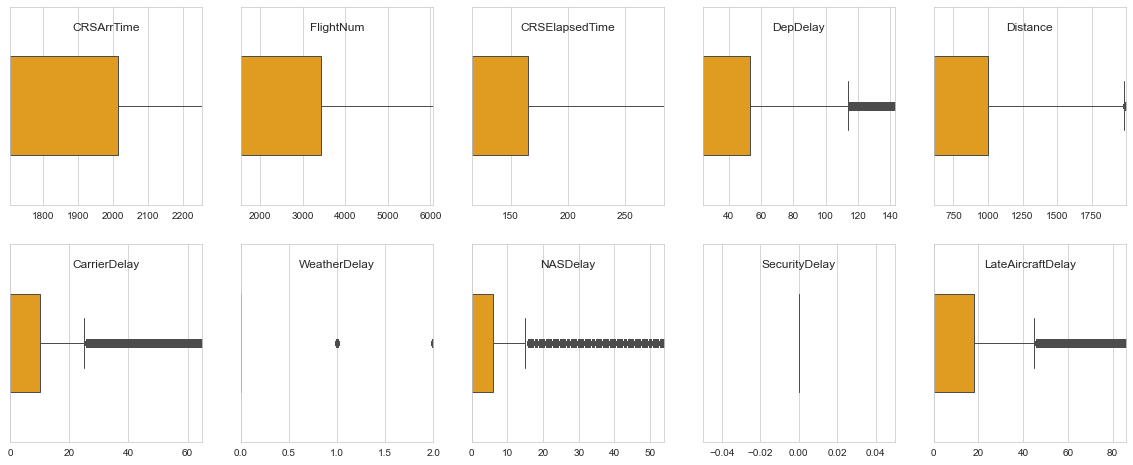

In [136]:
#aprofitem que describe ens retorna columnes numèriques per crear dos indexs pels dos tipus de variables
num_cols = X_desc.index.tolist()
cat_cols = X.columns.drop(X_desc.index).tolist()

#dibuixem els boxplots de les dades d'entrada d'entrenament. Podem observar tb els outliers de les variables 
distplots(X_train, X_train[num_cols].drop(columns=time_cols), color="orange")

In [137]:
#extraiem les dades estadístiques descriptives, amb la mateixa info pel conjunt de prova de variables d'entrada
#veiem que al ser mostres grans de dades, tenen tb pràcticament la mateixa distribució
test_desc = X_test.describe().T.rename(columns=ren).drop(columns=drop).add_suffix(":test")
test_desc[test_desc.columns.sort_values()].drop(index=time_cols)

,max:test,mean:test,median:test,min:test,std:test
CRSArrTime,"2,359.00","1,633.81","1,705.00",0.00,465.25
FlightNum,"9,740.00","2,184.22","1,544.00",1.00,"1,942.75"
CRSElapsedTime,660.00,134.13,116.00,8.00,71.10
DepDelay,"2,457.00",43.04,24.00,6.00,53.30
Distance,"4,962.00",764.53,606.00,11.00,573.08
CarrierDelay,"1,707.00",12.38,0.00,0.00,36.24
WeatherDelay,"1,153.00",2.40,0.00,0.00,17.26
NASDelay,"1,357.00",9.71,0.00,0.00,28.19
SecurityDelay,209.00,0.06,0.00,0.00,1.49
LateAircraftDelay,"1,236.00",16.34,0.00,0.00,35.88


<ipython-input-123-8e9efe0610d7>:30: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(df[col].quantile(q=.5), df[col].quantile(q=.95))


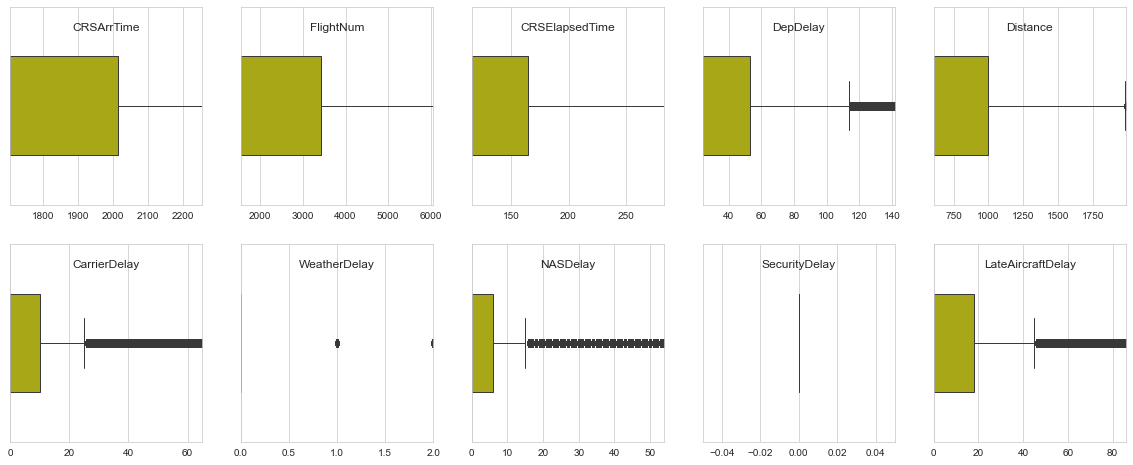

In [138]:
#dibuixem els boxplots ara per les dades d'entrada de prova. Comprovem visualment com son distribucions practicament iguals al
#dataset i a l'entrenament, doncs hi ha una quantitat considerable d'instàncies que favoreix que així sigui.
distplots(X_test, X_test[num_cols].drop(columns=time_cols), color="y")

In [139]:
#dels grups de variables d'entrada podrem analitzar les categòriques.
#Contem els valors únics pels conjunts d'entrenament i prova, i també els del dataset al complet.

#La funció que definim calcula els valors únics i está modificada amb parámetres, a posteriori, per l'exercici següent
def valors_unics(df, cols, total_cols=False, binary=False):
    total = 0
    for col in cols:
        num_values = len(df[col].unique().tolist())
        if binary == False: total += num_values
        print(f"Variable {col}: {num_values} valors únics")
        if binary == True:
            bin_size = math.ceil(math.log2(num_values))
            total += bin_size
            print(f"Tamany necessari per la codificació binaria de {num_values} valors únics: {bin_size}\n")
    if total_cols: print(f"Total de columnes noves: {total}")
        
print("Conjunt d'entrenament:")
valors_unics(X_train, cat_cols)
print("\nConjunt de prova:")
valors_unics(X_test, cat_cols)
print("\nTot el dataset:")
valors_unics(df, cat_cols)

Conjunt d'entrenament:
Variable UniqueCarrier: 20 valors únics
Variable TailNum: 5356 valors únics
Variable Origin: 302 valors únics
Variable Dest: 301 valors únics

Conjunt de prova:
Variable UniqueCarrier: 20 valors únics
Variable TailNum: 5339 valors únics
Variable Origin: 302 valors únics
Variable Dest: 301 valors únics

Tot el dataset:
Variable UniqueCarrier: 20 valors únics
Variable TailNum: 5361 valors únics
Variable Origin: 303 valors únics
Variable Dest: 302 valors únics


*Observant el nombre de valors únics per variable categòrica del número d'avió (TailNum), veiem que és una gran quantitat de "matrícules" d'aeronaus úniques que, a sobre, ens requerirà un cost important computacional al haver d'augmentar considerablement el nombre de variables.*

*A priori, no sembla massa probable que els retards vagin influenciats per l'aeronau en concret, tot i que es podria evaluar. Però semblaria més lògic agrupar-los per models d'aeronaus en general, (per exemple mapejant el model per cada "matrícula" amb un dataset complementari que ens haurien de proporcionar).*

*A més a més, aquestes "matricules" poden ser reutilitzades quan una aeronau es retira de la flota, amb el que es podria donar el cas que un TailNum pertanyés a dos aeronaus (més no crec doncs son dades únicament d'un any)*

In [140]:
#comparem les distribucions de tota la variable objectiu amb les d'entrenament i de prova
pd.concat([y.describe(), y_train.describe(), y_test.describe()], axis=1)

,ArrDelay,ArrDelay_train,ArrDelay_test
count,"1,928,371.00","1,157,022.00","771,349.00"
mean,42.20,42.23,42.15
std,56.78,56.76,56.82
min,-109.00,-69.00,-109.00
25%,9.00,9.00,9.00
50%,24.00,24.00,24.00
75%,56.00,56.00,56.00
max,"2,461.00","2,453.00","2,461.00"


*Aquí veiem les mateixes distribucions, però també observem una diferència de rang, sobretot de mínims entre els conjunts causats per outliers.*

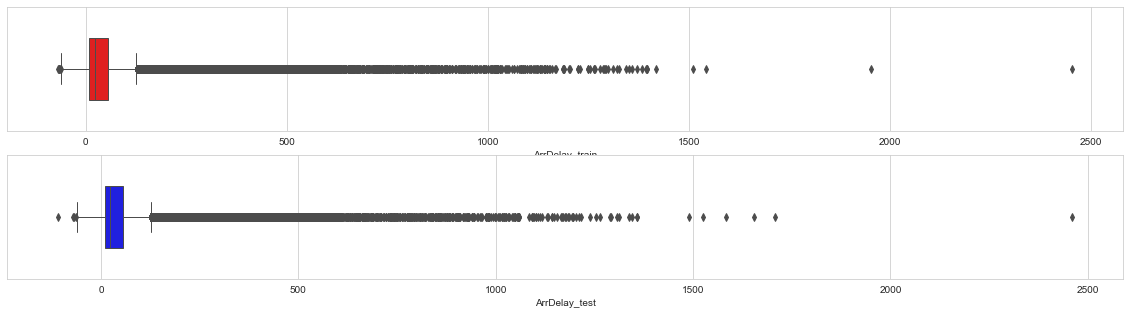

In [141]:
#visualitzem gràficament
plt.figure(figsize=(20,5))
plt.subplot(2, 1, 1)
sns.boxplot(x=y_train, color="r", orient='h', linewidth=1 , width=.5)
plt.subplot(2, 1, 2)
sns.boxplot(x=y_test, color="b", orient='h', linewidth=1 , width=.5)
plt.show()

## Exercici
Aplica algun procés de transformació (estandarditzar les dades numèriques, crear columnes dummies, polinomis...).

*Farem primer les codificacions de variables categòriques i les transformacions (no lineals) de variables numèriques, per deixar per al final l'estandarització (lineal), Així deixarem les dades amb unes distribucions de variances unitàries i mitjanes nul·les*

### Crear columnes dummies

In [142]:
#fem una copia de X_train per anar agregant les transformacions a X_train_trans
X_train_trans = X_train.copy()

#com hem vist en l'exercici anterior hi tenim una gran quantitat de valors únics en algunes caracteristiques de la nostra
#font de dades. Tornem a treure els valors únics de les columnes categòriques mostrant el total d'unics (o columnes a afegir). 
#Fent un get_dummies, en el nostre cas, implicaria 5979 columnes noves
print("Conjunt d'entrenament:")
valors_unics(X_train, cat_cols, total_cols=True)

Conjunt d'entrenament:
Variable UniqueCarrier: 20 valors únics
Variable TailNum: 5356 valors únics
Variable Origin: 302 valors únics
Variable Dest: 301 valors únics
Total de columnes noves: 5979


*Per exemple, per les columnes amb un alt nombre d'únics podríem fer-hi **codificació binària** (que ens generarà un nou nombre de columnes tal que el logaritme en base 2 de número de valors únics). I per la columna UniqueCarrier, farem una **codificació amb get_dummies**.*

*Com el nostre es un cas de regressió podem usar n-1 columnes passant el paràmetre drop_first=True, tot i que si haguéssim d'utilitzar posteriorment un model d'aprenetatge basat en arbres hauríem d'usar les n columnes*.

In [143]:
#partim d'un dataframe amb 21 columnes
print("columnes inicials:", len(X_train_trans.columns))

#Fem el get_dummies de UniqueCarrier. (21 cols) - (1 UniqueCarrier) + (20 - 1 dummies) = 39
data = pd.get_dummies(X_train_trans.UniqueCarrier, drop_first=True, prefix="UniqueCarrier", prefix_sep=":")
X_train_trans = X_train_trans.drop(columns="UniqueCarrier").join(data)
X_train_trans.shape

columnes inicials: 21


(1157022, 39)

In [144]:
#comparem els únics amb les columnes generades
print("Valors únics de codis d'aerolínies:")
values = X_train.UniqueCarrier.unique().tolist()
values.sort()
print(np.array(values), "\n")

print("Valors únics de codis d'aerolínies convertits a columnes (get_dummies) :")
print(data.columns.to_series().str.replace("UniqueCarrier:", "").values, "\n")

#podem veure com per valors d'UniqueCarrier = 9E (l'eliminada), codificaria amb zeros totes les columnes de l'instància
print("Valors de columnes per la primera instància amb UniqueCarrier = 9E:")
index = X_train[X_train.UniqueCarrier == "9E"].index[0]
print(data.loc[index].values)

Valors únics de codis d'aerolínies:
['9E' 'AA' 'AQ' 'AS' 'B6' 'CO' 'DL' 'EV' 'F9' 'FL' 'HA' 'MQ' 'NW' 'OH'
 'OO' 'UA' 'US' 'WN' 'XE' 'YV'] 

Valors únics de codis d'aerolínies convertits a columnes (get_dummies) :
['AA' 'AQ' 'AS' 'B6' 'CO' 'DL' 'EV' 'F9' 'FL' 'HA' 'MQ' 'NW' 'OH' 'OO'
 'UA' 'US' 'WN' 'XE' 'YV'] 

Valors de columnes per la primera instància amb UniqueCarrier = 9E:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Codificació binària

In [145]:
#Podem calcular el nombre de noves columnes que tindrem per variable, i el total, si els apliquem la codificació binària
cols = cat_cols.copy()
cols.remove('UniqueCarrier')

print("Conjunt d'entrenament:\n")
valors_unics(X_train, cols, total_cols=True, binary=True)

Conjunt d'entrenament:

Variable TailNum: 5356 valors únics
Tamany necessari per la codificació binaria de 5356 valors únics: 13

Variable Origin: 302 valors únics
Tamany necessari per la codificació binaria de 302 valors únics: 9

Variable Dest: 301 valors únics
Tamany necessari per la codificació binaria de 301 valors únics: 9

Total de columnes noves: 31


In [146]:
#Recordem que haviem conservat els nulls a TailNum. Mirem pel conjunt d'entrenament i ens n'apareix un
index = X_train[X_train.TailNum.isna()].index
index

Int64Index([1643793], dtype='int64')

In [147]:
#apliquem la codificació binària a les variables categòriques menys a UniqueCarrier, que ja hem transformat.
#No codificarem el null com un valor binari sino que aquesta instància la deixarem nula en la codificació de la variable
binary_enc = category_encoders.BinaryEncoder(cols=cols, return_df=True, handle_missing="return_nan")
binary_enc.fit(X_train_trans)
X_train_trans = binary_enc.transform(X_train_trans)
X_train_trans.shape

(1157022, 70)

In [148]:
#comprovem el null i veiem que ens ha retornat els NaNs esperats
X_train_trans.loc[index][X_train_trans.columns[X_train_trans.columns.str.contains("Tail")]]

,TailNum_0,TailNum_1,TailNum_2,TailNum_3,TailNum_4,TailNum_5,TailNum_6,TailNum_7,TailNum_8,TailNum_9,TailNum_10,TailNum_11,TailNum_12,TailNum_13
1643793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
#veiem tb que tenim 70 columnes quan n'hauriem de tenir: 39 + (31 calculades per codificar) - (3 que hem codificat) = 67
#observem que de cada variable generada en la codificació binària tenim una columna més de les que esperàvem obtenir
for n in range(len(cols)):
    enc_cols = binary_enc.base_n_encoder.mapping[n]["mapping"].columns
    print(f"Nombre de columnes per {cols[n]}: {len(enc_cols)}")
    print(f"Columnes generades: {enc_cols.to_list()}\n")

Nombre de columnes per TailNum: 14
Columnes generades: ['TailNum_0', 'TailNum_1', 'TailNum_2', 'TailNum_3', 'TailNum_4', 'TailNum_5', 'TailNum_6', 'TailNum_7', 'TailNum_8', 'TailNum_9', 'TailNum_10', 'TailNum_11', 'TailNum_12', 'TailNum_13']

Nombre de columnes per Origin: 10
Columnes generades: ['Origin_0', 'Origin_1', 'Origin_2', 'Origin_3', 'Origin_4', 'Origin_5', 'Origin_6', 'Origin_7', 'Origin_8', 'Origin_9']

Nombre de columnes per Dest: 10
Columnes generades: ['Dest_0', 'Dest_1', 'Dest_2', 'Dest_3', 'Dest_4', 'Dest_5', 'Dest_6', 'Dest_7', 'Dest_8', 'Dest_9']



In [150]:
#busquem columnes amb valors únics o amb la variança = 0
#veiem que ens genera 1 columna de més, la de pes mes alt, amb zeros com a valor únic (seria com afegir un zero a l'esquerra)
data = X_train_trans.var() == 0
index = data.index[data]
for col in index: print(X_train_trans[col].value_counts(), "\n")

0.00    1157021
Name: TailNum_0, dtype: int64 

0.00    1157022
Name: Origin_0, dtype: int64 

0.00    1157022
Name: Dest_0, dtype: int64 



In [151]:
#..no ens aporten res. Eliminem aquestes columnes per reduïr el tamany
X_train_trans.drop(columns=index, inplace=True)
len(X_train_trans.columns)

67

### Transformació polinòmica de columnes numèriques

Amb la transformació polinòmica generem noves columnes: 
- els productes de les combinacions entre elles 
- elevant cada variable un nombre de graus que definim amb degree. (=2 per defecte)
- en genera tb una columna de bias

In [152]:
#calculem les noves columnes que ens seran generades:
n = len(num_cols)
print(f"Noves columnes de bias: 1")
print(f"Variables numèriques originals: {n}")
print(f"Noves columnes de combinacions: {math.comb(n, 2)}")
print(f"Noves columnes d'elevar al quadrat (degree=2):  {n}\n")
print(f"Total columnes per les {n} variables (incloent originals): {math.comb(n, 2) + n*2 + 1}")

Noves columnes de bias: 1
Variables numèriques originals: 17
Noves columnes de combinacions: 136
Noves columnes d'elevar al quadrat (degree=2):  17

Total columnes per les 17 variables (incloent originals): 171


In [153]:
#generem les columnes (no afegim la columna de bias que ens afegeix tot d'uns)
data = X_train_trans[num_cols]

polynomial_enc = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
polynomial_enc.fit(data)

#tindrem una columna menys al no haver inclòs el bias
print("Columnes totals generades:", polynomial_enc.n_output_features_)

#generem les noves columnes polinòmiques 
data = polynomial_enc.transform(data)

#extraiem els nous noms de les columnes generades i agreguem les polinòmiques a un dataframe amb els noms
cols = polynomial_enc.get_feature_names(num_cols)
data = pd.DataFrame(data, columns=cols)
print("Dimensions sortida PolynomialFeatures:", data.shape)

#afegim les polinòmiques al dataframe de transformacions (eliminant les variables originals que ens les retorna tb)
#hauriem de tenir: (70 que teniem abans) + (170 generades) - (20 originals que ens duplica) = 220
X_train_trans = X_train_trans.drop(columns=num_cols).join(data.set_index(X_train_trans.index))
X_train_trans.shape

Columnes totals generades: 170
Dimensions sortida PolynomialFeatures: (1157022, 170)


(1157022, 220)

In [154]:
#podem observar, per exemple, les diferents distribucions generades amb "DepDelay"
cols = X_train_trans.columns[X_train_trans.columns.str.contains("DepDelay")]
X_train_trans[cols].describe().T.drop(columns=drop)

,mean,std,min,50%,max
DepDelay,43.12,53.24,6.00,24.00,"2,467.00"
Month DepDelay,264.12,410.17,6.00,124.00,"17,136.00"
DayofMonth DepDelay,681.60,"1,045.19",6.00,323.00,"41,715.00"
DayOfWeek DepDelay,172.83,258.07,6.00,84.00,"10,815.00"
CRSArrTime DepDelay,"71,812.95","93,271.27",0.00,"38,280.00","3,959,535.00"
FlightNum DepDelay,"99,717.31","188,989.48",6.00,"36,039.50","6,662,244.00"
CRSElapsedTime DepDelay,"5,812.17","9,052.75",30.00,"2,925.00","659,835.00"
DepDelay^2,"4,694.36","23,307.61",36.00,576.00,"6,086,089.00"
DepDelay Distance,"32,736.07","59,516.29",186.00,"14,872.00","5,540,940.00"
DepDelay CarrierDelay,"1,629.02","18,468.89",0.00,0.00,"6,009,612.00"


In [155]:
#desem les veriables DepDelay i DepDelay^2 abans d'estandaritzar per visualitzar a l'excercici següent
data = X_train_trans[["DepDelay", "DepDelay^2"]]

### Normalització estàndard

*Tot i que, en principi, no seria necessari estandaritzar les columnes binàries he trobat algunes [opinions](https://datascience.stackexchange.com/questions/31652/should-one-hot-vectors-be-scaled-with-numerical-attributes) que afirmen que proporcionen petites millores en entrenaments per models de xarxes neuronals o basats en mètriques de distància.*

*Per aquest motiu les estandaritzarem totes.*

In [156]:
#finalment apliquem la transformació lineal d'estandarització a totes les dades
standardscaler = preprocessing.StandardScaler()

index = X_train_trans.index
X_train_trans = pd.DataFrame(standardscaler.fit_transform(X_train_trans), columns=X_train_trans.columns, index=index)

#observem les transformacions a les mateixes combinacions de DepDelay
X_train_trans[cols].describe().T.drop(columns=drop)

,mean,std,min,50%,max
DepDelay,0.00,1.00,-0.70,-0.36,45.53
Month DepDelay,-0.00,1.00,-0.63,-0.34,41.13
DayofMonth DepDelay,-0.00,1.00,-0.65,-0.34,39.26
DayOfWeek DepDelay,-0.00,1.00,-0.65,-0.34,41.24
CRSArrTime DepDelay,-0.00,1.00,-0.77,-0.36,41.68
FlightNum DepDelay,0.00,1.00,-0.53,-0.34,34.72
CRSElapsedTime DepDelay,0.00,1.00,-0.64,-0.32,72.25
DepDelay^2,-0.00,1.00,-0.20,-0.18,260.92
DepDelay Distance,0.00,1.00,-0.55,-0.30,92.55
DepDelay CarrierDelay,-0.00,1.00,-0.09,-0.09,325.30


## Exercici
Resumeix les noves columnes generades de manera estadística i gràfica

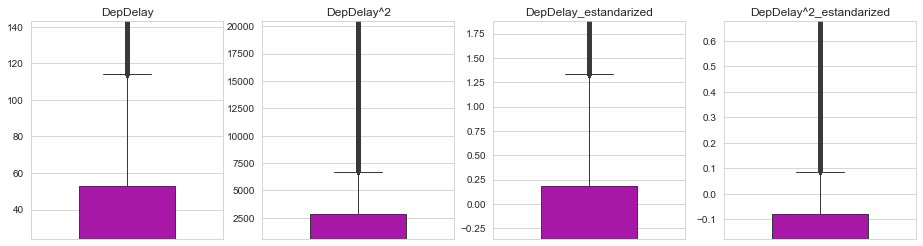

In [157]:
#Com a mostra del procés de transformació visualitzem les distribucons de la transformació de DepDelay y exponencial
data = data.join(X_train_trans[["DepDelay", "DepDelay^2"]].add_suffix("_estandarized"))
distplots(data, data.columns, color="m", orient="v")

In [158]:
#observem com han quedat les 17 columnes numèriques (estandatitzades)
X_train_trans[num_cols].describe().T.rename(columns=ren).drop(columns="count")

,mean,std,min,25%,median,75%,max
Month,-0.00,1.00,-1.47,-0.89,-0.03,0.83,1.69
DayofMonth,-0.00,1.00,-1.68,-0.88,0.03,0.83,1.74
DayOfWeek,0.00,1.00,-1.50,-0.99,0.01,1.01,1.51
CRSArrTime,-0.00,1.00,-3.52,-0.67,0.15,0.82,1.56
FlightNum,-0.00,1.00,-1.12,-0.81,-0.33,0.64,3.88
CRSElapsedTime,0.00,1.00,-1.87,-0.73,-0.26,0.43,7.37
DepDelay,0.00,1.00,-0.70,-0.58,-0.36,0.19,45.53
Distance,-0.00,1.00,-1.31,-0.74,-0.28,0.41,7.31
CarrierDelay,0.00,1.00,-0.34,-0.34,-0.34,-0.07,66.99
WeatherDelay,0.00,1.00,-0.14,-0.14,-0.14,-0.14,77.33


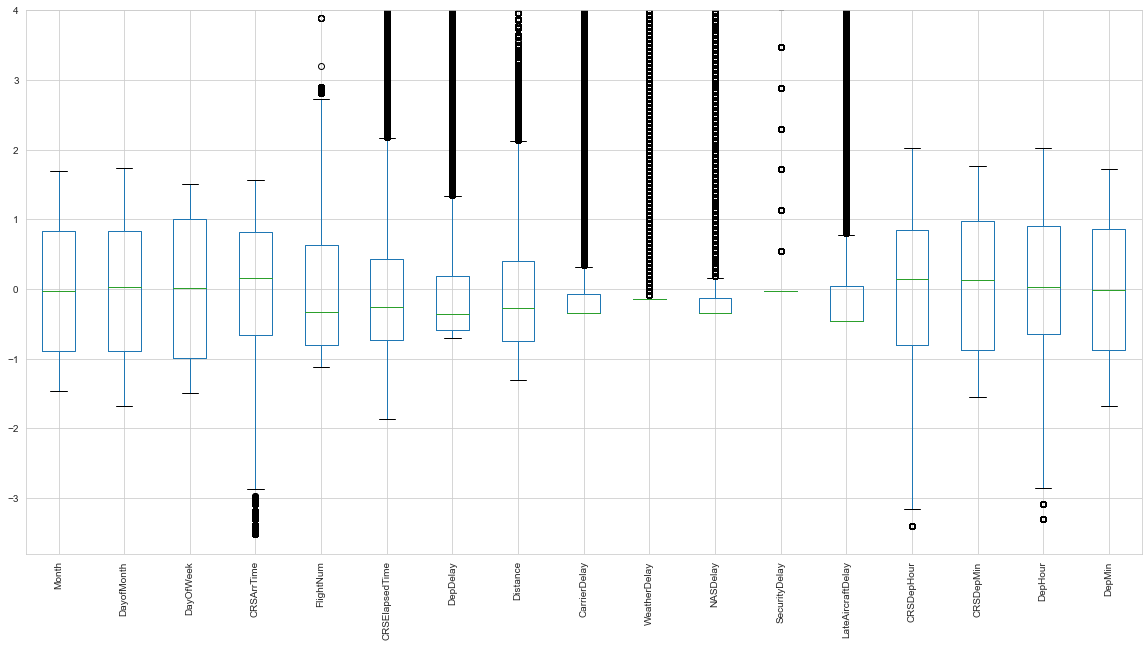

In [159]:
#visualitzem gràficament en paral·lel
plt.figure(figsize=(20,10))
X_train_trans.boxplot(column=num_cols, rot=90)
plt.ylim(-3.8, 4)
plt.show()

In [160]:
#observem, per exemple, les exponencials
cols = [col + "^2" for col in num_cols]
X_train_trans[cols].describe().T.rename(columns=ren).drop(columns="count")

,mean,std,min,25%,median,75%,max
Month^2,0.00,1.00,-1.04,-0.87,-0.29,0.68,2.03
DayofMonth^2,-0.00,1.00,-1.14,-0.92,-0.24,0.72,2.24
DayOfWeek^2,-0.00,1.00,-1.16,-0.97,-0.24,0.99,1.79
CRSArrTime^2,0.00,1.00,-2.07,-0.81,0.01,0.84,1.92
FlightNum^2,0.00,1.00,-0.67,-0.64,-0.49,0.25,6.79
CRSElapsedTime^2,0.00,1.00,-0.83,-0.59,-0.35,0.15,14.90
DepDelay^2,-0.00,1.00,-0.20,-0.20,-0.18,-0.08,260.92
Distance^2,-0.00,1.00,-0.62,-0.54,-0.37,0.05,15.94
CarrierDelay^2,-0.00,1.00,-0.08,-0.08,-0.08,-0.08,331.56
WeatherDelay^2,0.00,1.00,-0.05,-0.05,-0.05,-0.05,284.25


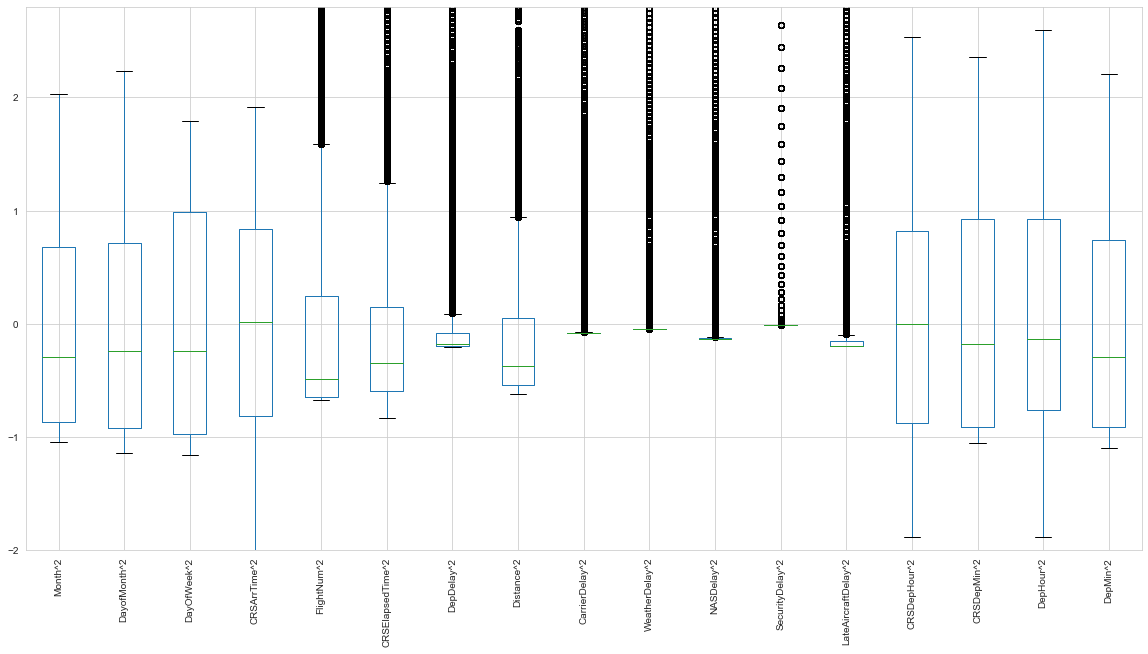

In [161]:
#mirem les transformacions exponencials sobre les columnes numèriques (i posteriorment estandaritzades)
cols = [col + "^2" for col in num_cols]

plt.figure(figsize=(20,10))
X_train_trans.boxplot(column=cols, rot=90)
plt.ylim(-2, 2.8)
plt.show()

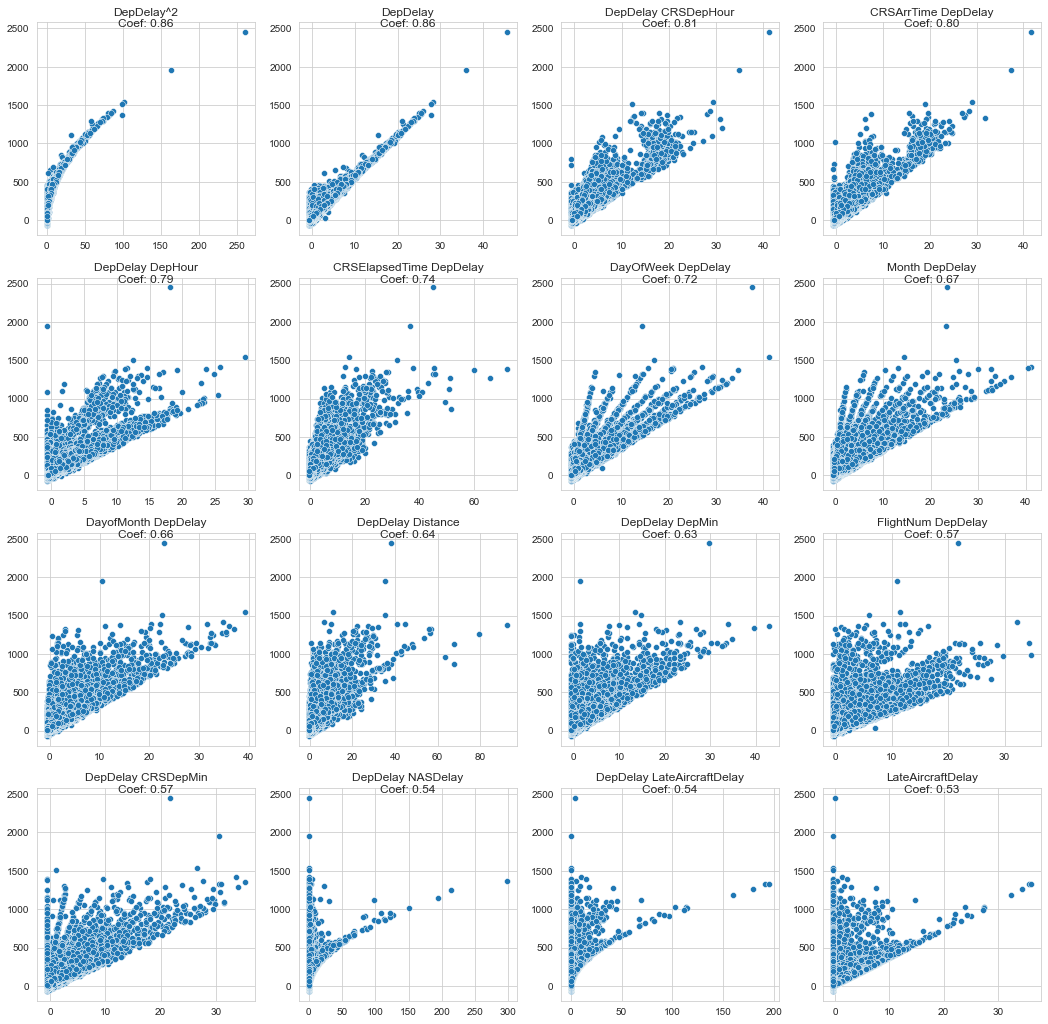

In [162]:
#per exemple podriem buscar les correlacions de les variables amb la variable objectiu
#utilitzem la correlació d'spearman doncs funciona millor amb distribucions no normals i és menys sensible als outliers
data = X_train_trans.apply(lambda x: spearmanr(x, y_train).correlation)

#seleccionem les 16 variables amb major correlació, en valor absolut
data = abs(data).sort_values(ascending=False).head(16)
index = data.index

#dibuixem els scatters de les variables numèriques més correlacionades amb la variable objectiu
plt.figure(figsize=(18, 18))
for i in range(len(index)):
    plt.subplot(4, 4, i+1)
    sns.scatterplot(x=X_train_trans[index[i]], y=y_train)
    plt.title(index[i] + "\nCoef: {0:.2f}".format(data[index[i]]), y=.95)
    plt.xlabel("")
    plt.ylabel("")
plt.show()